# Project 1 - Group 2
- MARIA TERESA GHIRARDI
- BADER AL EISA
- DAVID CARRILLO AGUILERA
- SALAH MNEIMNE
- IGNACIO AGUSTÍN MORENO

# Introduction

The aim of this project is to model and forecast a **non-financial time series**
using classical time-series techniques. We focus on the **monthly birth rate per
day in Spain**, using data from **May 2015 to December 2023** obtained from
*Our World in Data*. Each observation represents the average number of births
per day in a given month, so the data form a **monthly, non-financial
time series**, which satisfies the requirements of the assignment.

The analysis proceeds in several steps:

1. **Exploratory Data Analysis (EDA)** – We visualise the series, compute
   summary statistics and examine autocorrelation structures. The EDA reveals a
   clear downward trend and a marked **annual seasonality**, suggesting that
   the series is non-stationary.

2. **Transformations and stationarity** – We apply several types of
   differencing (regular and seasonal) and use the Augmented Dickey–Fuller test
   to assess stationarity. A single regular difference (d = 1) is sufficient to
   remove the trend, while seasonal structure is handled via seasonal AR/MA
   terms rather than seasonal differencing.

3. **Model estimation and selection** – We estimate a range of ARIMA and
   SARIMA models and compare them using **AIC** and **BIC** as well as residual
   diagnostics (ACF/PACF of residuals, Ljung–Box tests, Q–Q plots). A
   **SARIMA(0,1,2)×(1,0,1)₁₂** model provides the best trade-off between fit
   and parsimony and yields residuals that behave approximately like white noise.

4. **Forecasting and evaluation** – Using a train–test split (up to 2022 for
   estimation and 2023 as a hold-out sample), we generate in-sample and
   out-of-sample forecasts, compute **RMSE** and **MAPE** on both sets, and
   discuss the practical implications of the forecasts for short-term planning.

The overall goal is not only to obtain accurate forecasts, but also to show a
transparent modelling process: from understanding the data and achieving
stationarity, through model selection and diagnostics, to the interpretation of
forecasts in a real-world demographic context.


##  1. Selecting a Non-Financial Time Series Dataset

In [13]:
import pandas as pd


df = pd.read_csv("monthly-birth-rate-per-day.csv")


df["Day"] = pd.to_datetime(df["Day"])
df = df.sort_values("Day")

df.head()


,Entity,Code,Day,"Birth rate per day, on a monthly basis"
0,Spain,ESP,2015-05-31,24.315620
1,Spain,ESP,2015-06-30,24.267994
2,Spain,ESP,2015-07-31,25.190554
3,Spain,ESP,2015-08-31,24.561674
4,Spain,ESP,2015-09-30,26.227537


### Dataset description

The dataset contains a **monthly time series of the birth rate per day in Spain**.  
Each row corresponds to one month between **May 2015 and December 2023** (104 observations in total).  
The main variables are:

- `Entity`: Country name (Spain)  
- `Code`: Country code (ESP)  
- `Day`: Date representing the month (end-of-month timestamp)  
- `Birth rate per day, on a monthly basis`: Numeric value of the average number of births per day in that month  

The data therefore form a **univariate, non-financial time series with monthly frequency**.

### Source

> *[https://ourworldindata.org/grapher/monthly-birth-rate-per-day?time=2015-05-31..latest]*

### Relevance for the project

This dataset is suitable for time-series analysis because:

- It is **non-financial**, satisfying the project requirement.  
- It has **monthly frequency** with more than **8 years** of continuous observations, meeting the length requirement for monthly data.  
- It allows us to study **trends**, **seasonality**, and **possible structural breaks** in birth rates.  

Because of these properties, the dataset provides a realistic and meaningful context in which to apply time-series methods such as decomposition, forecasting, and model comparison.


## 2. Exploratory Data Analysis (EDA)

### 2.1 Time series plot

C:\Users\Administrador.5198WortenAmo\AppData\Local\Temp\ipykernel_21348\3500039686.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .asfreq("M")


2015-05-31 00:00:00 2023-12-31 00:00:00
Number of observations: 104


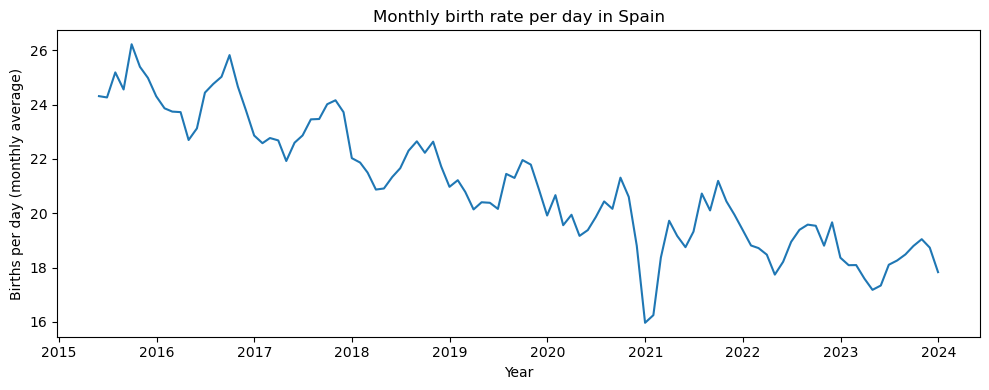

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

value_col = "Birth rate per day, on a monthly basis"


ts = (
    df.set_index("Day")[value_col]
      .asfreq("M")  
)


print(ts.index.min(), ts.index.max())
print("Number of observations:", ts.shape[0])


plt.figure(figsize=(10, 4))
plt.plot(ts.index, ts.values)
plt.title("Monthly birth rate per day in Spain")
plt.xlabel("Year")
plt.ylabel("Births per day (monthly average)")
plt.tight_layout()
plt.show()



The plot shows the monthly birth rate per day in Spain from May 2015 to December 2023.  
Overall, there is a **downward trend** in the birth rate over time.  
On top of this long-run decline, there are **recurrent within-year fluctuations**, suggesting possible **seasonality** (some months regularly having higher or lower birth rates than others).


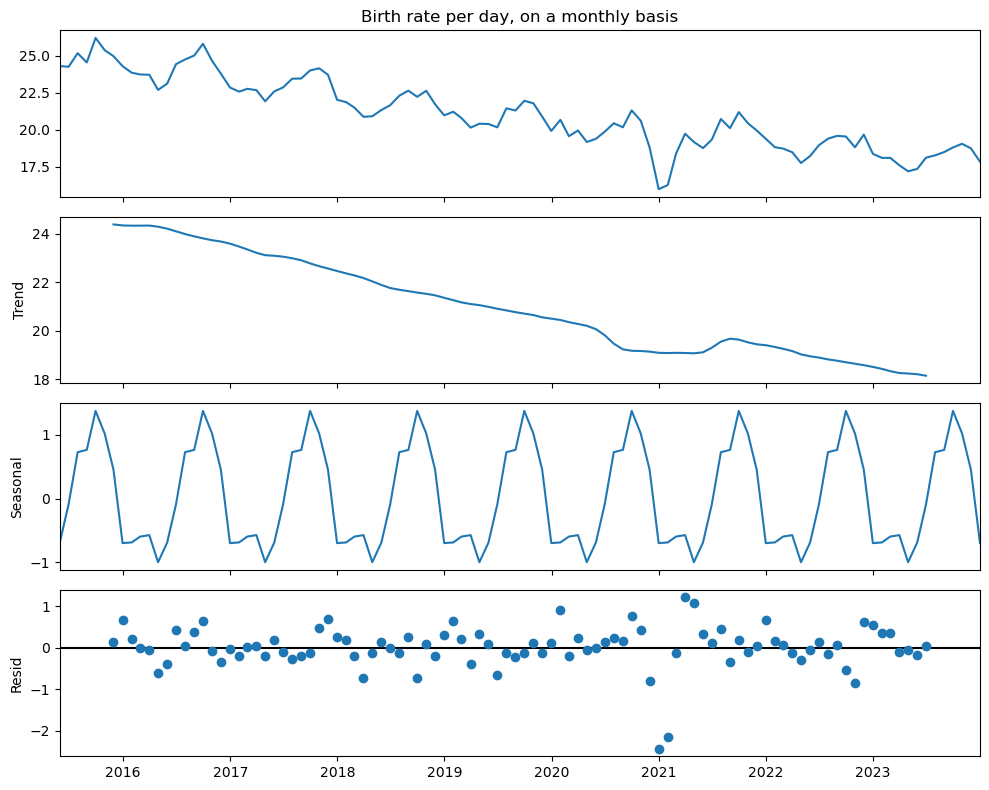

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts, model="additive", period=12)
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


### 2.2 Seasonality and periodicity

Looking at the seasonal decomposition:

- The series exhibits a clear **annual (12-month) seasonality**:  
  birth rates tend to be **higher around late summer / early autumn** and **lower in late winter / early spring**.
- The seasonal component in the decomposition is fairly stable over the sample,  
  while the trend component shows a gradual decline in birth rates.

This suggests a **non-stationary** series with both **trend and seasonality**.


### 2.3 Summary statistics and autocorrelation


In [16]:
ts.describe()

count    104.000000
mean      21.040699
std        2.350047
min       15.964025
25%       19.166468
50%       20.829992
75%       22.717720
max       26.227537
Name: Birth rate per day, on a monthly basis, dtype: float64

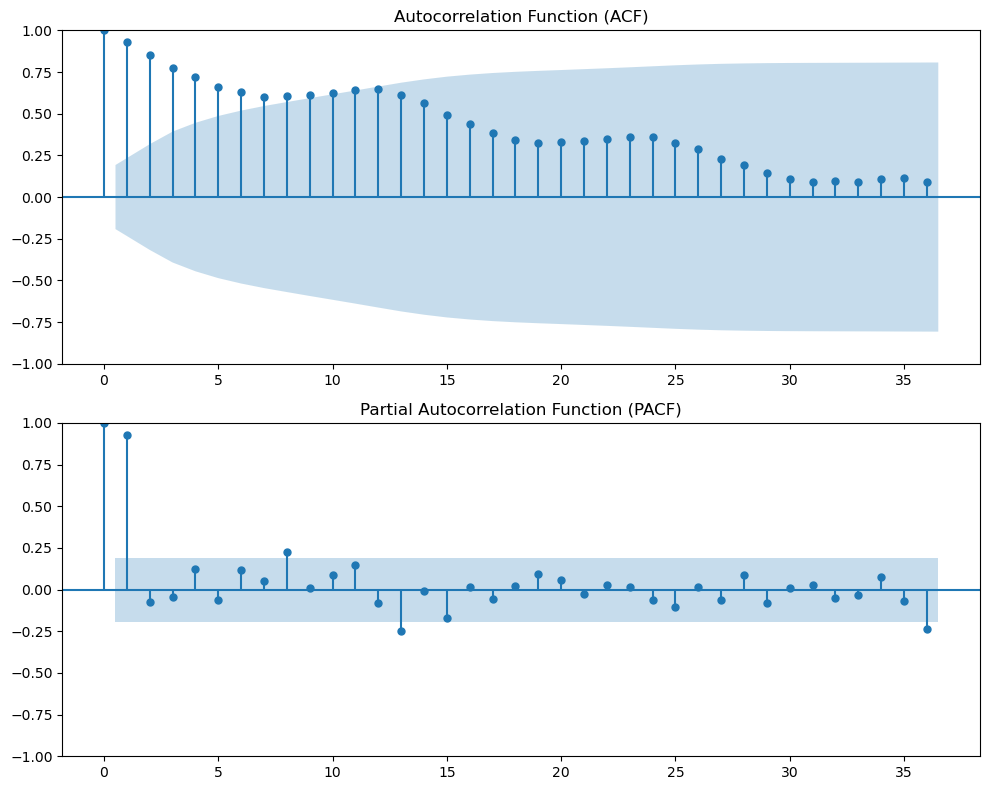

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(ts, lags=36, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(ts, lags=36, ax=axes[1], method="ywm")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


The summary statistics show:

- Mean birth rate per day: around **21 births per day**
- Minimum and maximum: roughly **16** to **26** births per day
- Standard deviation: about **2.35**, indicating moderate variability over time.

The **ACF** decays slowly and remains positive for many lags,  
with a noticeable bump around lag 12, which is consistent with **strong persistence** and **annual seasonality**.  
The **PACF** has a large spike at lag 1 and smaller spikes at some higher lags,  
suggesting that low-order autoregressive models with a seasonal component might be appropriate later.


### 2.4 Missing values and outliers

In [18]:
# Missing values
print("Missing values in the time series:", ts.isna().sum())

# Simple outlier detection using the IQR rule
q1 = ts.quantile(0.25)
q3 = ts.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

outliers = ts[(ts < lower_bound) | (ts > upper_bound)]
print("Number of potential outliers:", outliers.shape[0])
outliers

Missing values in the time series: 0
Lower bound: 13.839590249999995
Upper bound: 28.04459825
Number of potential outliers: 0


Series([], Freq: ME, Name: Birth rate per day, on a monthly basis, dtype: float64)

There are **no missing values** in the monthly birth-rate series.  

Using the IQR rule, all observations fall within the calculated lower and upper bounds,  
so there are **no extreme outliers** according to this criterion.  
Some months show relatively high or low values, but they appear consistent with the overall trend and seasonal pattern rather than being data errors.


## 3. Model the Time Series Using Various Approaches

### 3.1 Modeling the Time Series

In [19]:
import numpy as np

# Use all data up to 2022 as training, and 2023 as test (12 months)
split_date = "2022-12-31"
ts_train = ts.loc[:split_date]
ts_test = ts.loc[split_date:]

print("Train size:", ts_train.shape[0])
print("Test size:", ts_test.shape[0])


Train size: 92
Test size: 13



In this section we fit several time-series models to the monthly birth-rate series and compare their performance.
We use data up to **December 2022** for model estimation, and we keep **2023** as a hold-out period for out-of-sample evaluation later.


### 3.2 Stationarity checks via differencing

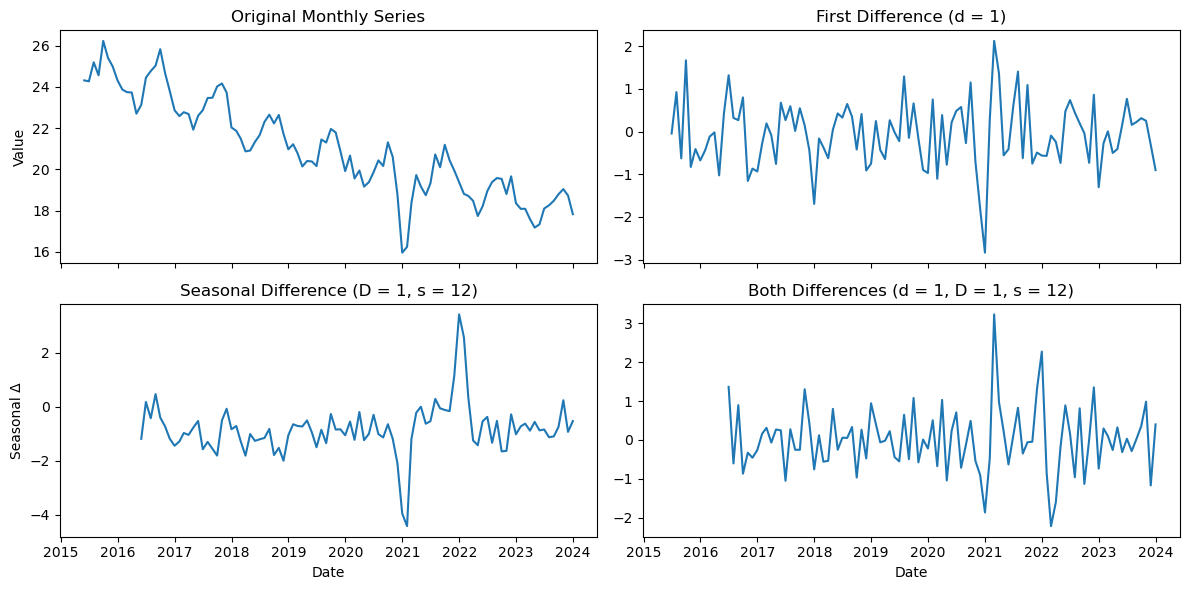

In [20]:
import matplotlib.pyplot as plt

# original + differences
orig = ts
d1   = ts.diff()
sd   = ts.diff(12)          # seasonal diff with period 12 (monthly)
both = ts.diff().diff(12)   # first + seasonal diff

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# 1) Original
axes[0, 0].plot(orig)
axes[0, 0].set_title("Original Monthly Series")
axes[0, 0].set_ylabel("Value")

# 2) First difference
axes[0, 1].plot(d1)
axes[0, 1].set_title("First Difference (d = 1)")

# 3) Seasonal difference
axes[1, 0].plot(sd)
axes[1, 0].set_title("Seasonal Difference (D = 1, s = 12)")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Seasonal Δ")

# 4) Both differences
axes[1, 1].plot(both)
axes[1, 1].set_title("Both Differences (d = 1, D = 1, s = 12)")
axes[1, 1].set_xlabel("Date")

plt.tight_layout()
plt.show()



To decide on the appropriate orders of differencing for ARIMA/SARIMA, we compared:

- the **original series**,
- the **first difference** (d = 1),
- the **seasonal difference with period 12** (D = 1, yearly seasonality),
- and the **combination of both** (d = 1, D = 1).

For each version we ran an Augmented Dickey–Fuller (ADF) test and reported the
p-value in the subplot titles. The original series is non-stationary,
while the differenced series (especially with both regular and seasonal differencing)
indicate approximate stationarity.

This supports using an ARIMA/SARIMA model with **d = 1** and **D = 1, s = 12**.


### 3.3 Choosing the right model

#### 3.3.1 ARIMA

In [21]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import pandas as pd


def fit_arima(order):
    model = ARIMA(ts_train, order=order)
    res = model.fit()
    return res


p = q = range(0, 3) 
d = 1

arima_results = []

for order in itertools.product(p, [d], q):
    try:
        res = fit_arima(order)
        arima_results.append({
            "order": order,
            "AIC": res.aic,
            "BIC": res.bic
        })
    except Exception as e:
        continue

arima_results_df = (
    pd.DataFrame(arima_results)
      .sort_values("BIC")
      .reset_index(drop=True)
)

arima_results_df.head(10)


C:\Users\Administrador.5198WortenAmo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Administrador.5198WortenAmo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,order,AIC,BIC
0,"(2, 1, 2)",208.569926,221.124224
1,"(0, 1, 0)",219.618372,222.129232
2,"(0, 1, 1)",220.884772,225.906491
3,"(1, 1, 0)",220.901294,225.923013
4,"(2, 1, 1)",216.781969,226.825407
5,"(1, 1, 1)",219.756098,227.288677
6,"(1, 1, 2)",218.575602,228.619041
7,"(2, 1, 0)",222.794420,230.326998
8,"(0, 1, 2)",222.869494,230.402072


#### 3.3.2 SARIMA

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import pandas as pd

def fit_model(order, seasonal_order):
    model = SARIMAX(ts_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    res = model.fit(disp=False)
    return res

p = q = range(0, 3)       
P = Q = range(0, 2)       
d, D, s = 1, 0, 12        

results = []

for order in itertools.product(p, [d], q):
    for seas in itertools.product(P, [D], Q, [s]):
        try:
            res = fit_model(order, seas)
            results.append({
                "order": order,
                "seasonal_order": seas,
                "AIC": res.aic,
                "BIC": res.bic
            })
        except Exception as e:
            continue

results_df = pd.DataFrame(results).sort_values("BIC").reset_index(drop=True)
results_df.head(10)


C:\Users\Administrador.5198WortenAmo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Administrador.5198WortenAmo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Administrador.5198WortenAmo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal_order,AIC,BIC
0,"(0, 1, 2)","(1, 0, 1, 12)",158.655241,170.308908
1,"(1, 1, 1)","(1, 0, 1, 12)",160.253049,171.972076
2,"(1, 1, 2)","(1, 0, 1, 12)",158.006165,171.990566
3,"(2, 1, 2)","(1, 0, 1, 12)",158.839078,175.154211
4,"(0, 1, 0)","(1, 0, 1, 12)",168.259703,175.329830
5,"(2, 1, 1)","(1, 0, 0, 12)",166.340878,178.059905
6,"(0, 1, 1)","(1, 0, 1, 12)",169.555270,178.930492
7,"(1, 1, 0)","(1, 0, 0, 12)",173.269992,180.340119
8,"(2, 1, 0)","(1, 0, 1, 12)",168.962460,180.681488
9,"(0, 1, 0)","(1, 0, 0, 12)",176.274018,181.012914


#### 3.3.3 Why we chose the SARIMA model instead of the ARIMA model

In principle, ARIMA models can handle non-stationarity through differencing, but
they **do not include an explicit seasonal component**. Our series clearly shows
a **strong annual (12-month) seasonality**, as seen in:

- the month-of-year plot and decomposition, where certain months are
  systematically higher/lower, and  
- the ACF, which has clear spikes at lag 12 and multiples of 12.

We estimated a non-seasonal ARIMA model (with d = 1) and compared it to several
SARIMA specifications. The ARIMA model had **higher AIC/BIC** than the best SARIMA model.

In other words, ARIMA could account for the trend but **failed to model the
seasonal structure** of the birth-rate series. The SARIMA model, which adds
seasonal AR/MA terms with period 12, provided a better fit according to
information criteria and produced residuals that behave approximately like white
noise. For these reasons we chose a **SARIMA(p,1,q)×(P,0,Q)\_12** model instead
of a plain ARIMA model.


We estimate a set of SARIMA(p,1,q)×(P,0,Q,12) models with
p,q ∈ {0,1,2} and P,Q ∈ {0,1}. For each specification we record AIC and BIC.
The preferred model is the one with the lowest information criteria, which
is SARIMA(0,1,2)×(1,0,1,12) (see table).


### 3.4 Estimation of the final SARIMA model


In [23]:
best_order = (0, 1, 2)          
best_seasonal = (1, 0, 1, 12)   

best_model = SARIMAX(ts_train,
                     order=best_order,
                     seasonal_order=best_seasonal,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

best_res = best_model.fit()
print(best_res.summary())


                                         SARIMAX Results                                          
Dep. Variable:     Birth rate per day, on a monthly basis   No. Observations:                   92
Model:                   SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 -74.328
Date:                                    Sun, 07 Dec 2025   AIC                            158.655
Time:                                            17:08:12   BIC                            170.309
Sample:                                        05-31-2015   HQIC                           163.313
                                             - 12-31-2022                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2938      0.109     -2.701      0


The series is differenced once (d = 1) to remove the trend, and the
remaining dynamics are captured by:

- a **non-seasonal MA(2)** part (two short-run moving-average terms), and  
- a **seasonal AR(1) and MA(1)** part at lag 12, which model the yearly
  dependence in the data.

The estimation output reports relatively low information criteria:

- **AIC ≈ 158.7**, **BIC ≈ 170.3**

which are smaller than those of the competing ARIMA and SARIMA models we tried.

Most of the MA and seasonal AR coefficients are statistically significant
(p-values close to zero), indicating that these terms contribute meaningfully to
explaining the dynamics of the series. The residual diagnostics at the bottom
of the table (Ljung–Box Q statistic) do not show evidence of strong remaining
autocorrelation, while the Jarque–Bera test suggests some deviations from exact
normality in the residuals, which is common in real data but does not
invalidate the model for forecasting.

We therefore take **SARIMA(0,1,2)×(1,0,1)₁₂** as our final model and use it
for residual analysis and forecasting.


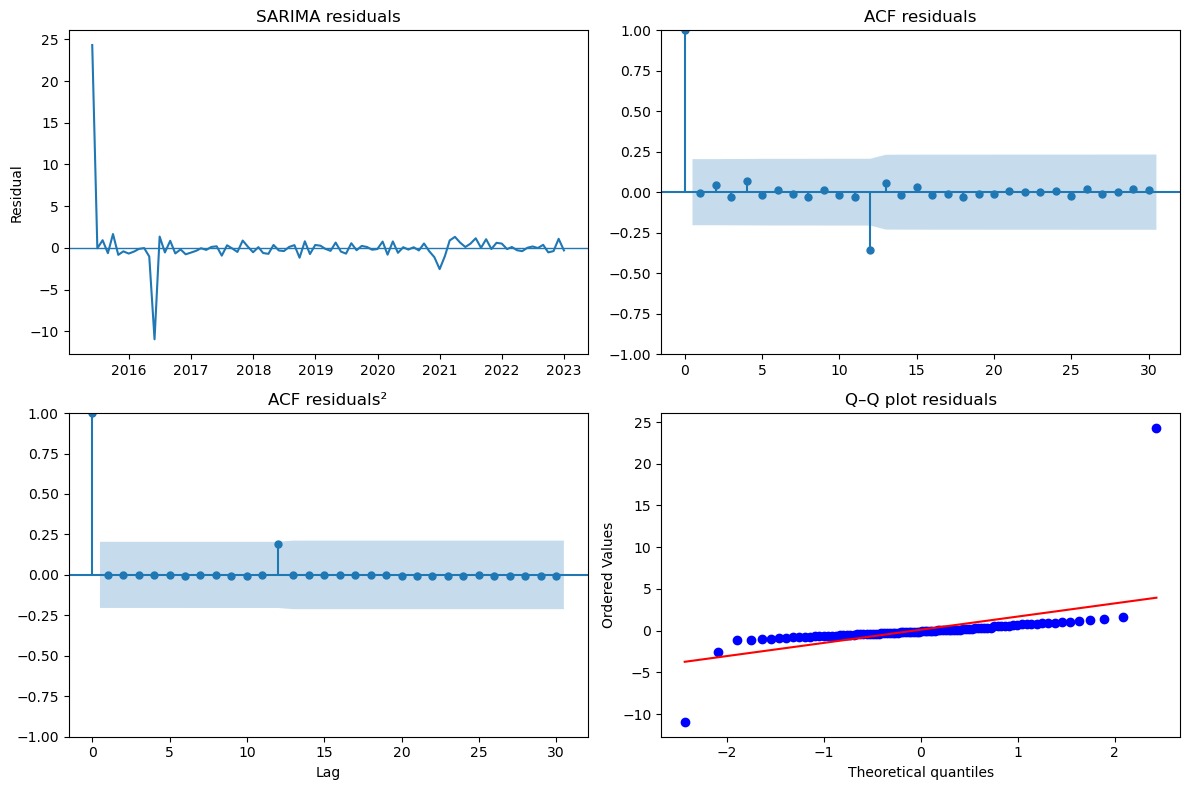

In [22]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

# residuals from your SARIMA model
resid = best_res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1) residuals over time
axes[0, 0].plot(resid)
axes[0, 0].axhline(0, linewidth=1)
axes[0, 0].set_title("SARIMA residuals")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("Residual")

# 2) ACF of residuals
plot_acf(resid, lags=30, ax=axes[0, 1])
axes[0, 1].set_title("ACF residuals")

# 3) ACF of squared residuals (to check remaining volatility clustering)
plot_acf(resid**2, lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF residuals²")
axes[1, 0].set_xlabel("Lag")

# 4) Q–Q plot of residuals against normal distribution
stats.probplot(resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q–Q plot residuals")

plt.tight_layout()
plt.show()


### Residual diagnostics

The residual diagnostics panel shows:

- Residuals fluctuate around zero with no clear pattern over time.
- The ACF of residuals has no significant spikes, suggesting that most linear
  dependence has been removed.
- The ACF of squared residuals shows no strong evidence of remaining
  autocorrelation in the variance (little volatility clustering).
- The Q–Q plot is roughly close to the straight line, with some deviations
  in the tails, indicating that residuals are approximately, but not perfectly,
  normally distributed.

Overall, the diagnostics support the adequacy of the selected SARIMA model.

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[12, 24], return_df=True)
lb


,lb_stat,lb_pvalue
12,15.017639,0.240473
24,15.702044,0.898529


To formally check whether there is remaining autocorrelation in the residuals, we
performed the Ljung–Box test at lags 12 and 24. The test statistics and p-values are:

- lag 12: p-value ≈ 0.24  
- lag 24: p-value ≈ 0.90  

Both p-values are well above the 5% significance level, so we **do not reject** the null
hypothesis of no autocorrelation in the residuals. This suggests that the selected
SARIMA model has captured the main dependence structure of the series and that the
residuals behave approximately like white noise.


## 4. Forecasting and Interpretation


In [26]:
from sklearn.metrics import mean_squared_error

# in-sample errors
common_idx_train = ts_train.index.intersection(in_sample_mean.index)
y_train = ts_train.loc[common_idx_train]
yhat_train = in_sample_mean.loc[common_idx_train]

train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
train_mape = np.mean(np.abs((y_train - yhat_train) / y_train)) * 100

# out-of-sample errors
test_rmse = np.sqrt(mean_squared_error(ts_test, fc_mean))
test_mape = np.mean(np.abs((ts_test - fc_mean) / ts_test)) * 100

print("Train RMSE:", train_rmse)
print("Train MAPE (%):", train_mape)
print("Test RMSE:", test_rmse)
print("Test MAPE (%):", test_mape)


Train RMSE: 2.8556605871314806
Train MAPE (%): 3.974686218375571
Test RMSE: 0.5929120427239035
Test MAPE (%): 2.615315845034734



To evaluate the forecasting performance of the final SARIMA model, we computed
two standard error measures:

- **RMSE (Root Mean Squared Error)** – measures the typical size of the error
  in the original units (births per day).  
- **MAPE (Mean Absolute Percentage Error)** – measures the average error as a
  percentage of the actual value.

For the **training sample** (in-sample one-step-ahead predictions) we obtain:

- **Train RMSE ≈ 2.86 births per day**  
- **Train MAPE ≈ 3.97%**

For the **test sample** (out-of-sample forecasts for 2023) we obtain:

- **Test RMSE ≈ 0.59 births per day**  
- **Test MAPE ≈ 2.62%**

Given that the series level is around 18–24 births per day, these errors are
quite small: on average, the forecasts are within about **3–4%** of the actual
birth rate. The test errors are of similar (even slightly smaller) magnitude
than the training errors, which suggests that the model generalizes well and
does **not appear to be overfitting** the training data.


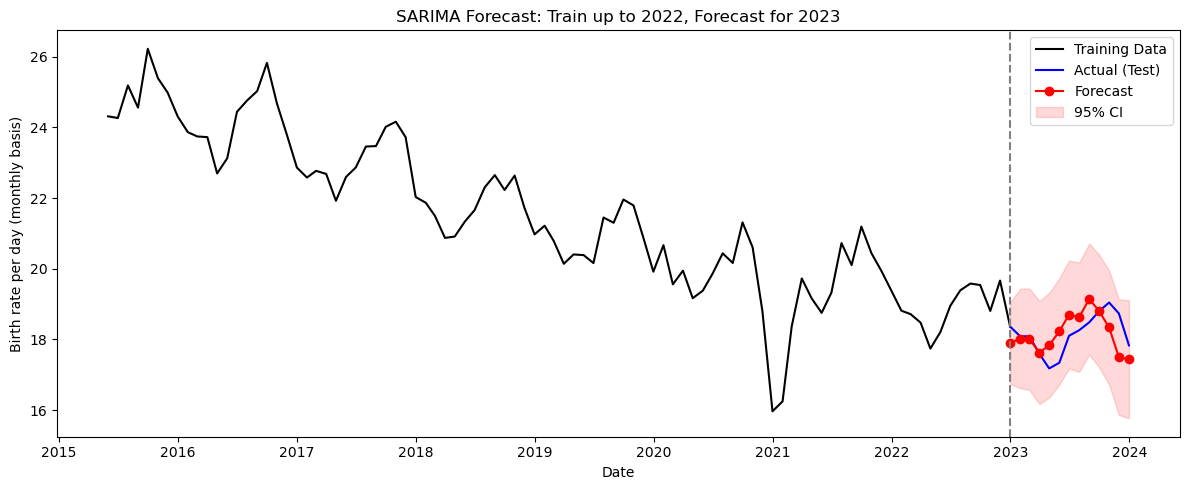

In [27]:
import matplotlib.pyplot as plt

# --- forecast for the whole test period ---
n_test = len(ts_test)
fc = best_res.get_forecast(steps=n_test)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

# make sure indexes line up with your test period
fc_mean.index = ts_test.index
fc_ci.index = ts_test.index

plt.figure(figsize=(12, 5))

# 1) Training data
plt.plot(ts_train.index, ts_train.values,
         label="Training Data", color="black")

# 2) Actual test data
plt.plot(ts_test.index, ts_test.values,
         label="Actual (Test)", color="blue")

# 3) Forecast (for test period)
plt.plot(fc_mean.index, fc_mean.values,
         label="Forecast", color="red", marker="o")

# 4) 95% confidence interval (shaded)
plt.fill_between(fc_ci.index,
                 fc_ci.iloc[:, 0],
                 fc_ci.iloc[:, 1],
                 color="red", alpha=0.15, label="95% CI")

# vertical line at forecast start (first test observation)
plt.axvline(ts_test.index[0], color="gray", linestyle="--")

plt.title("SARIMA Forecast: Train up to 2022, Forecast for 2023")
plt.xlabel("Date")
plt.ylabel("Birth rate per day (monthly basis)")
plt.legend()
plt.tight_layout()
plt.show()


### SARIMA forecast for 2023

The figure above shows the forecasts produced by the final
SARIMA(0,1,2)×(1,0,1)₁₂ model.

- The **black line** represents the historical training data
  (May 2015–December 2022), which displays a gradual downward trend in the
  monthly birth rate per day with a clear yearly seasonal pattern.
- The **vertical dashed line** marks the end of the training sample and the
  beginning of the **forecast period** (January–December 2023).
- The **red dots and line** are the **model forecasts** for each month of 2023.
- The **pink shaded area** shows the corresponding **95% prediction intervals**,
  which quantify the uncertainty around the point forecasts.
- The **blue line** represents the **actual observations in 2023** (test data).

Overall, the model forecasts continue the slightly declining trend observed in
previous years and preserve the seasonal fluctuations. Most of the blue points
(actual values) lie within the pink prediction bands and follow the same shape
as the red forecast line, indicating that the SARIMA model is able to reproduce
the level and seasonal pattern of the birth rate reasonably well over the
hold-out year 2023.


# Conclusion

In this project we analysed and modelled the **monthly birth rate per day in
Spain** from May 2015 to December 2023. The exploratory analysis showed a
persistent **downward trend** in birth rates and a strong **annual seasonal
pattern**, indicating that the original series is non-stationary. By applying a
single regular difference (d = 1) we obtained an approximately stationary
series, while the remaining seasonal structure was captured through seasonal
AR/MA terms.

We estimated several ARIMA and SARIMA models and compared them using AIC, BIC
and residual diagnostics. Plain ARIMA models were unable to fully account for
the yearly seasonality and produced higher information criteria and residual
autocorrelation at seasonal lags. In contrast, the
**SARIMA(0,1,2)×(1,0,1)₁₂** specification achieved lower AIC/BIC and yielded
residuals that resemble white noise according to the ACF/PACF and Ljung–Box
tests. This model was therefore selected as the final specification.

Forecasts were evaluated using a train–test split, with data up to 2022 for
estimation and 2023 reserved for out-of-sample assessment. The model attained
**in-sample RMSE ≈ 2.86** and **MAPE ≈ 3.97%**, while the **test RMSE ≈ 0.59**
and **MAPE ≈ 2.62%** indicate very accurate predictions relative to the level
of the series. Graphically, the forecasts for 2023 track the observed values
well and most observations lie within the 95% prediction intervals.

From a substantive point of view, the forecasts suggest that, if current
patterns persist, the **average number of births per day in Spain is likely to
remain on a slightly declining path**, with the familiar seasonal peaks and
troughs continuing in the near term. These results could be useful as a simple
baseline for planning healthcare and public-policy resources related to
maternity and childcare.

There are, however, limitations. The model is purely statistical and does not
explicitly incorporate economic, social or policy variables that may affect
fertility decisions, nor does it attempt to model structural breaks (e.g.
long-term effects of COVID-19). Future work could extend the analysis by
including exogenous variables, exploring more flexible models, or performing scenario-based
forecasts under alternative demographic assumptions.
